In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img
)
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import (
    Dropout,
    Flatten,
    Dense,
    Input,
    AveragePooling2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import pandas
from google.colab.patches import cv2_imshow
from PIL import Image
import random

## Prepare project structure

### Retrieving dataset

In [2]:
%%bash
curl -s -o dataset.tar.gz http://image.ntua.gr/iva/datasets/flickr_logos/flickr_logos_27_dataset.tar.gz
tar -xzf dataset.tar.gz
tar -xzf flickr_logos_27_dataset/flickr_logos_27_dataset_images.tar.gz

### Cleanung up folder structure

In [3]:
%%bash
rm -rf sample_data
mv flickr_logos_27_dataset dataset
mv flickr_logos_27_dataset_images original_images
mv dataset/flickr_logos_27_dataset_query_set_annotation.txt test.txt
mv dataset/flickr_logos_27_dataset_training_set_annotation.txt train.txt
rm -rf dataset
rm dataset.tar.gz

### Separating train and test images

In [4]:
!mkdir train_images

In [5]:
with open("train.txt", "r") as f:
  train_df = pandas.DataFrame(
      [*map(lambda line: line.strip().split(" "), f.readlines())],
      columns=("img_src", "brand", "class", "x1", "y1", "x2", "y2")
  )
  train_df.x1 = [*map(int, train_df.x1)]
  train_df.y1 = [*map(int, train_df.y1)]
  train_df.x2 = [*map(int, train_df.x2)]
  train_df.y2 = [*map(int, train_df.y2)]

train_df.drop(columns=["class"], inplace=True)

In [6]:
code_to_brand = list(set(train_df.brand))
brand_to_code = dict(map(lambda a: (a[1], a[0]), enumerate(code_to_brand)))

In [7]:
train_df.brand = [*map(lambda brand: brand_to_code[brand], train_df.brand)]

In [8]:
for train_img_name in set(train_df.img_src.values):
  os.rename(f"./original_images/{train_img_name}", f"./train_images/{train_img_name}")

In [9]:
!mv original_images test_images

## Preprocessing

In [10]:
train_df = pandas.read_csv("./train.txt", sep='\s+', header=None)
train_df.columns = ("img_src", "brand", "class", "x1", "y1", "x2", "y2")
train_df

,img_src,brand,class,x1,y1,x2,y2
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93
...,...,...,...,...,...,...,...
4531,2126991906.jpg,Yahoo,6,15,6,253,54
4532,217288720.jpg,Yahoo,6,136,161,304,222
4533,2472817996.jpg,Yahoo,6,2,4,499,106
4534,2514220918.jpg,Yahoo,6,1,69,342,157


In [11]:
HEIGHT = 224
WIDTH =  224

In [12]:
!mkdir processed_train_images

In [13]:
for brand in set(train_df.brand.values):
  os.makedirs(f"./processed_train_images/{brand}")

In [14]:
for ((img_name, brand, _, x1, y1, x2, y2), index) in zip(train_df.values, train_df.index):
  try:
    image = cv2.imread(f"./train_images/{img_name}")
    image = image[y1:y2, x1:x2]
    image = cv2.resize(image, (WIDTH, HEIGHT))
    cv2.imwrite(f"./processed_train_images/{brand}/{img_name}", image)
  except:
    train_df.drop(index, inplace=True)

## Data augmentation

In [16]:
augmenter = ImageDataGenerator(
  rescale=1/255,
  horizontal_flip=True,
  vertical_flip=True,
  shear_range=0.2,
  zoom_range=0.2,
  featurewise_center=True,
  featurewise_std_normalization=True,
  rotation_range=40,
  width_shift_range=0.2,
  height_shift_range=0.2,
  fill_mode='nearest',
  validation_split = 0.2
)

In [17]:
EPOCHS = 50
BS = 512

In [18]:
train_data = augmenter.flow_from_directory("./processed_train_images",
  target_size=(WIDTH, HEIGHT),
  batch_size=BS,
  shuffle=False,
  # seed=42,
  color_mode="rgb",
  subset="training",
  class_mode="categorical"
)

Found 648 images belonging to 27 classes.


In [19]:
validation_data = augmenter.flow_from_directory("./processed_train_images",
  target_size=(WIDTH, HEIGHT),
  batch_size=BS,
  shuffle=False,
  # seed=42,
  color_mode="rgb",
  subset="validation",
  class_mode="categorical"
)

Found 161 images belonging to 27 classes.


## Create keras model

In [20]:
xception = Xception(include_top=False, input_tensor=Input(shape=(WIDTH, HEIGHT, 3)))

head_model = xception.output
head_model = AveragePooling2D(pool_size=(5, 5))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(train_data.num_classes, activation="softmax")(head_model)

model = Model(inputs=xception.input, outputs=head_model)

In [21]:
model.compile(
    loss="categorical_crossentropy",
    optimizer='Adam',
    metrics=["accuracy"]
)

In [22]:
model.load_weights("./x_weights.hdf5")

In [ ]:
checkpoint = ModelCheckpoint(
    filepath="x_weights.hdf5",
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [ ]:
history = model.fit(
	train_data,
  validation_data=validation_data,
	epochs=EPOCHS,
  callbacks=[checkpoint]
)

## Test

In [23]:
test_df = pandas.read_csv("./test.txt", sep='\s+', header=None)
test_df.columns = ("img_src", "brand")
test_df

,img_src,brand
0,2403695909.jpg,Adidas
1,2912587920.jpg,Adidas
2,3441398196.jpg,Adidas
3,4605630935.jpg,Adidas
4,4606245138.jpg,Adidas
...,...,...
265,3480640208.jpg,none
266,3486224308.jpg,none
267,3486430785.jpg,none
268,3490185235.jpg,none


In [31]:
brand_labels = list(train_data.class_indices.keys())

In [29]:
def predimage_for_array(img):
    test = cv2.resize(img, (WIDTH, HEIGHT))
    test = np.expand_dims(test, axis=0)
    test /= 255 
    result = model.predict(test, verbose=0)
    # return brand_labels[np.argmax(result)]
    return result

In [ ]:
brand_preds = list()
for file_name in test_df.img_src.values:
   img = load_img(f"./test_images/{file_name}", target_size=(WIDTH, HEIGHT))
   img = img_to_array(img)
   brand_preds.append(predimage_for_array(img))
   # brand_preds.append(predimage_(f"./test_images/{file_name}"))

In [ ]:
matches = 0
all = 0
for (gs, pred) in zip(test_df.brand.values, brand_preds):
  if gs == "none": continue
  matches += int(gs == brand_labels[np.argmax(pred)])
  all += 1


acc = matches / all
acc

0.5481481481481482

## Detection

In [24]:
WINDOW_WIDTH = 100
WINDOW_HEIGHT = 100
DETECTION_TRESHOLD = 0.95
STRIDE = 50
COUNT_OF_PREDICTIONS_TO_DRAW = 1

# (window_size, stride)
SLIDING_WINDOW_CONFIGS = (
    (200, 30),
)

In [25]:
!curl -o img.jpg "https://imgs.search.brave.com/KaLKPY_dg_PBT2sLzYRCvBPg4EAhNIX3WmigNVhEW8A/rs:fit:1200:1200:1/g:ce/aHR0cHM6Ly93d3cu/dGhlY29yay5pZS93/cC1jb250ZW50L3Vw/bG9hZHMvMjAyMC8w/Ni9IZWluZWtlbl9E/cmF1Z2h0X1ozQTQ3/MzMtc2NhbGVkLmpw/Zw"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  138k  100  138k    0     0  74525      0  0:00:01  0:00:01 --:--:-- 74486


In [26]:
img = load_img(f"./img.jpg")
img = img_to_array(img)
# cv2_imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

In [27]:
def sliding_window(image, stride, window_size):
	for y in range(0, image.shape[0], stride):
		for x in range(0, image.shape[1], stride):
			yield (x, y, image[y:y + window_size, x:x + window_size].copy())

In [32]:
significant_preds_for_configs = list()

for (window_size, stride) in SLIDING_WINDOW_CONFIGS:
  significant_preds = dict()
  
  for (x, y, window) in sliding_window(img, stride, window_size):
    if window.shape[0] != window_size or window.shape[1] != window_size:
      continue

    res = predimage_for_array(window)
    max_pred = np.amax(res[0])

    if(max_pred > DETECTION_TRESHOLD):
      key = brand_labels[np.argmax(res[0])]
      val = significant_preds.get(key)
      if val:
        val["x1"] = min(val["x1"], x)
        val["x2"] = max(val["x2"], x + window_size)
        val["y1"] = min(val["y1"], y)
        val["y2"] = max(val["y2"], y + window_size)
        val["matches"] += 1
        val["significance"] += max_pred
        val["significance"] /= 2


      else:
        significant_preds[key] = {
            "x1": x,
            "x2": x + window_size,
            "y1": y,
            "y2": y + window_size,
            "matches": 1,
            "significance": max_pred
        }

  significant_preds_for_configs.append(significant_preds)

In [33]:
significant_preds_for_configs

[{'DHL': {'x1': 30,
   'x2': 260,
   'y1': 30,
   'y2': 260,
   'matches': 3,
   'significance': 0.9798488020896912},
  'Heineken': {'x1': 540,
   'x2': 800,
   'y1': 390,
   'y2': 650,
   'matches': 5,
   'significance': 0.9641004130244255},
  'Unicef': {'x1': 210,
   'x2': 950,
   'y1': 900,
   'y2': 1190,
   'matches': 4,
   'significance': 0.9596128016710281}}]

In [34]:
best_preds = dict()

for dic in significant_preds_for_configs:
  for (brand, params) in dic.items():
    if best_preds.get(brand) is None:
      best_preds[brand] = {
          "x1": params["x1"],
          "x2": params["x2"],
          "y1": params["y1"],
          "y2": params["y2"],
          "matches": params["matches"],
          "significance": params["significance"]
      }

In [35]:
for (brand, coords) in sorted(list(best_preds.items()), key=lambda item: item[1]["matches"] * item[1]["significance"], reverse=True)[:COUNT_OF_PREDICTIONS_TO_DRAW]:
  (r, g, b) = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
  cv2.rectangle(img, (int(coords["x1"]), int(coords["y1"])), (int(coords["x2"]), int(coords["y2"])), (r, g, b), 1)
  cv2.putText(img, brand, (int(coords["x1"]), int(coords["y1"])), cv2.FONT_HERSHEY_PLAIN, 1, (r, g, b), 1, cv2.LINE_AA)

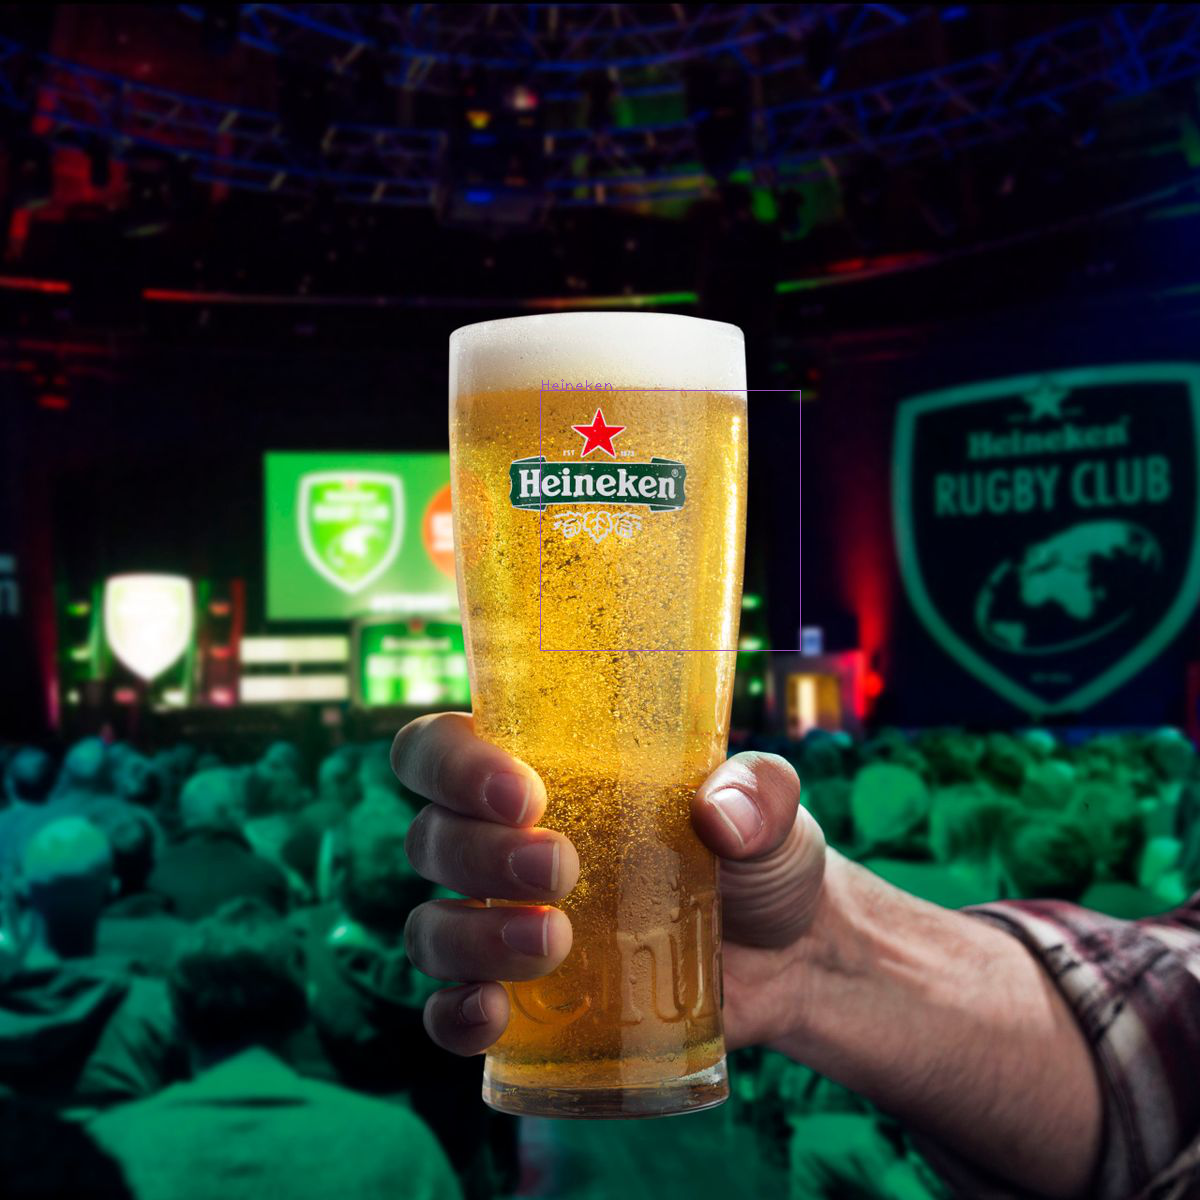

In [36]:
cv2_imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))